In [ ]:
!pip install pafy
!pip install youtube-dl

     |████████████████████████████████| 1.9 MB 14.0 MB/s 


In [ ]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

import os
import glob
import keras
import gc


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3940352/45929032 bytes (8.6%)8019968/45929032 bytes (17.5%)12115968/45929032 bytes (26.4%)16318464/45929032 bytes (35.5%)20373504/45929032 bytes (44.4%)24494080/45929032 bytes (53.3%)28647424/45929032 bytes (62.4%)32817152/45929032 bytes (71.5%)37036032/45929032 bytes (80.6%)41287680/45929032 bytes (89.9%)45506560/45929032 bytes (99.1%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
import concurrent.futures 
from time import sleep
from multiprocess import Pool
import pandas as pd

In [ ]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [ ]:
def plot_confusion_matrix_labeled(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [ ]:
#!pip install keras-video-generators

In [ ]:
#from tensorflow.keras.utils import Sequence
#from keras_video import VideoFrameGenerator

In [ ]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# !rm -r -f '/content/UCF50' 

**step 1 load data**

In [ ]:
!!cp -r "/content/gdrive/MyDrive/UCF50" "/content/" 

[]

In [ ]:
# !wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
# !unrar x UCF50.rar -inul -y

File ‘UCF50.rar’ already there; not retrieving.



**Step 2: Visualize the Data with its Labels**

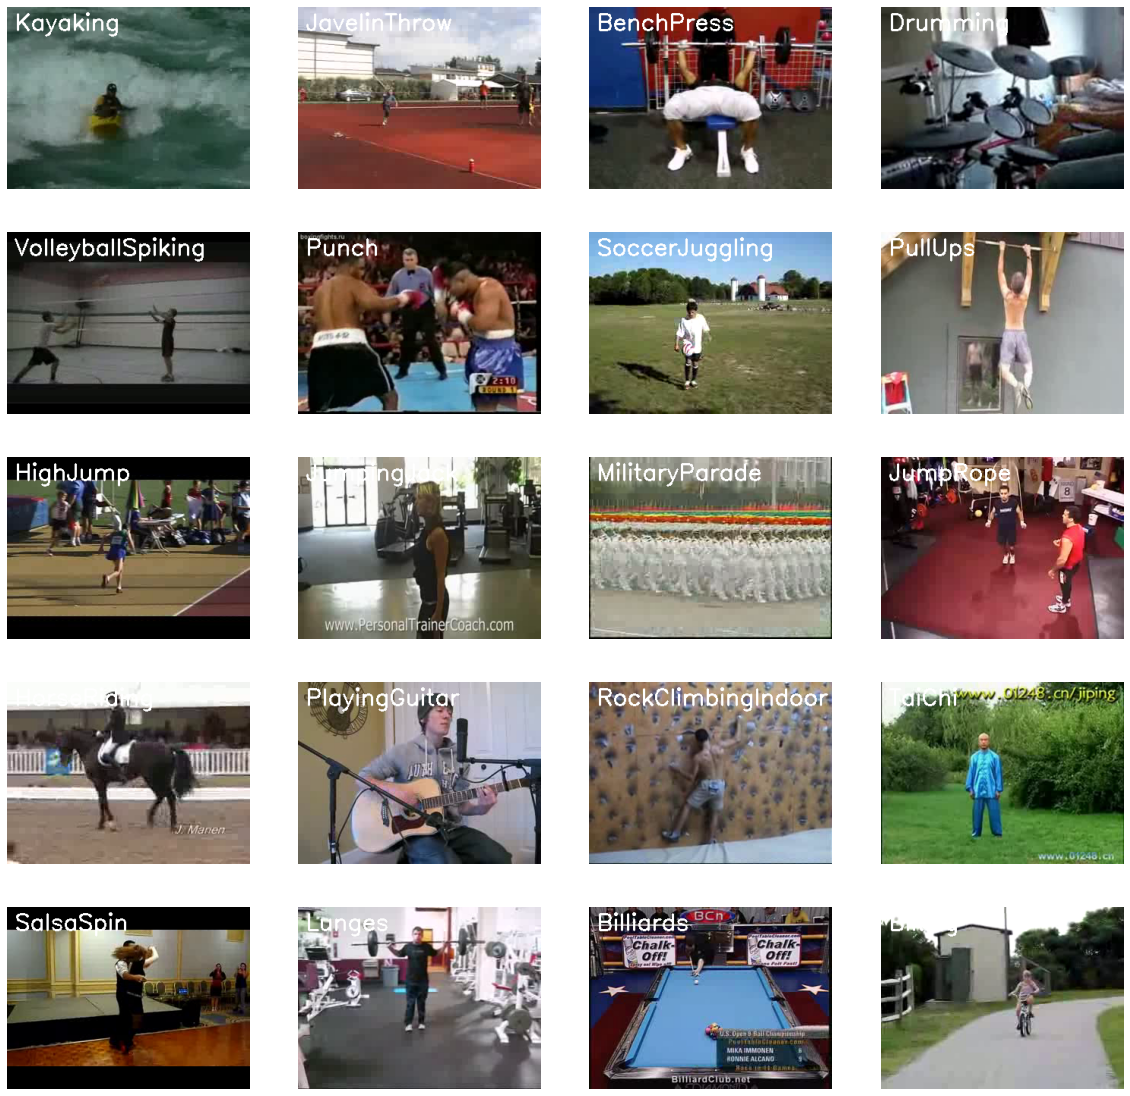

In [ ]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')

# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

**step 2 preprocess data**

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 10

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = sorted(list(os.listdir('UCF50')))#["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

In [ ]:
CLASSES_LIST

['BaseballPitch',
 'Basketball',
 'BenchPress',
 'Biking',
 'Billiards',
 'BreastStroke',
 'CleanAndJerk',
 'Diving',
 'Drumming',
 'Fencing',
 'GolfSwing',
 'HighJump',
 'HorseRace',
 'HorseRiding',
 'HulaHoop',
 'JavelinThrow',
 'JugglingBalls',
 'JumpRope',
 'JumpingJack',
 'Kayaking',
 'Lunges',
 'MilitaryParade',
 'Mixing',
 'Nunchucks',
 'PizzaTossing',
 'PlayingGuitar',
 'PlayingPiano',
 'PlayingTabla',
 'PlayingViolin',
 'PoleVault',
 'PommelHorse',
 'PullUps',
 'Punch',
 'PushUps',
 'RockClimbingIndoor',
 'RopeClimbing',
 'Rowing',
 'SalsaSpin',
 'SkateBoarding',
 'Skiing',
 'Skijet',
 'SoccerJuggling',
 'Swing',
 'TaiChi',
 'TennisSwing',
 'ThrowDiscus',
 'TrampolineJumping',
 'VolleyballSpiking',
 'WalkingWithDog',
 'YoYo']

**Extract, Resize and Normalize Frames**

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

**Dataset Creation**

In [ ]:
# uses # multthreading using process pool
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    feature = []
    label = []
    video_files_paths = []
  
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        gc.collect()
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        video_file_path = []
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path.append(os.path.join(DATASET_DIR, class_name, file_name))

        #     # Extract the frames of the video file.
        # with concurrent.futures.ProcessPoolExecutor() as executor:
        #   result = executor.map(frames_extraction, video_file_path)

            # Extract the frames of the video file.
        with concurrent.futures.ProcessPoolExecutor() as executor:
          result = executor.map(frames_extraction, video_file_path)

        # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
        # So ignore the vides having frames less than the SEQUENCE_LENGTH.
        for frames in result:
          if len(frames) == SEQUENCE_LENGTH:
        
            # # Append the data to their repective lists.
            feature.append(frames)
            label.append(class_index)
            #video_files_paths.append(video_file_path)
            gc.collect()

            

    # Converting the list to numpy arrays
    features = np.asarray(feature)
    del(feature)
    gc.collect()
    labels = np.array(label) 
    del(label) 
    gc.collect()
    # Return the frames, class index, and video file path.
    return features, labels #, video_files_paths

**create_dataset method which returns features and labels.**

In [ ]:
# import os
# import glob
# import keras
# from keras_video import VideoFrameGenerator
# # use sub directories names as classes
# classes = [i.split(os.path.sep)[1] for i in glob.glob('videos/*')]
# classes.sort()
# # some global params
# SIZE = (112, 112)
# CHANNELS = 3
# NBFRAME = 5
# BS = 8
# # pattern to get videos and classes
# glob_pattern='videos/{classname}/*.avi'
# # for data augmentation
# data_aug = keras.preprocessing.image.ImageDataGenerator(
#     zoom_range=.1,
#     horizontal_flip=True,
#     rotation_range=8,
#     width_shift_range=.2,
#     height_shift_range=.2)
# # Create video frame generator
# train = VideoFrameGenerator(
#     classes=classes, 
#     glob_pattern=glob_pattern,
#     nb_frames=NBFRAME,
#     split=.33, 
#     shuffle=True,
#     batch_size=BS,
#     target_shape=SIZE,
#     nb_channel=CHANNELS,
#     transformation=data_aug,
#     use_frame_cache=True)

In [ ]:
gc.collect()

254

In [ ]:
# Create the dataset.
features, labels = create_dataset()

Extracting Data of Class: BaseballPitch
Extracting Data of Class: Basketball
Extracting Data of Class: BenchPress
Extracting Data of Class: Biking
Extracting Data of Class: Billiards
Extracting Data of Class: BreastStroke
Extracting Data of Class: CleanAndJerk
Extracting Data of Class: Diving
Extracting Data of Class: Drumming
Extracting Data of Class: Fencing
Extracting Data of Class: GolfSwing
Extracting Data of Class: HighJump
Extracting Data of Class: HorseRace
Extracting Data of Class: HorseRiding
Extracting Data of Class: HulaHoop
Extracting Data of Class: JavelinThrow
Extracting Data of Class: JugglingBalls
Extracting Data of Class: JumpRope
Extracting Data of Class: JumpingJack
Extracting Data of Class: Kayaking
Extracting Data of Class: Lunges
Extracting Data of Class: MilitaryParade
Extracting Data of Class: Mixing
Extracting Data of Class: Nunchucks
Extracting Data of Class: PizzaTossing
Extracting Data of Class: PlayingGuitar
Extracting Data of Class: PlayingPiano
Extractin

In [ ]:
gc.collect()

50

 convert class labels to one hot encoded vectors

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

 Split the Data into Train and Test Sets

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [ ]:
features.shape

(6681, 20, 64, 64, 3)

In [ ]:
len(features.reshape(6681,  20*64*64 *3,1)[0])

245760

**Step 5: Construct the Model**

In [ ]:

def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

Model structure

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, 10, 62, 62, 4)     1024      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 31, 31, 4)    0         
 3D)                                                             
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 31, 31, 4)    0         
 tributed)                                                       
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 10, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 10, 15, 15, 8)    0         
 3D)                                                             
                                                      

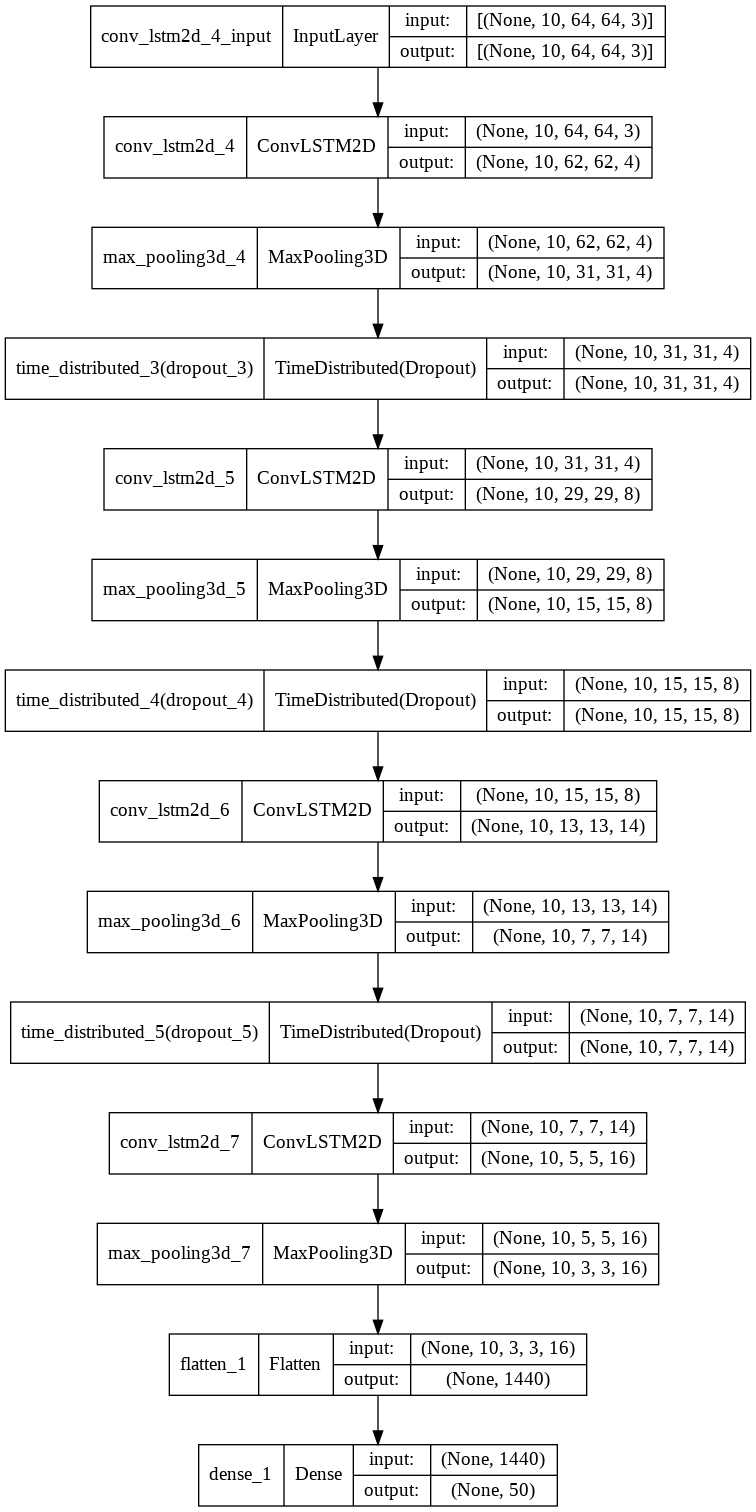

In [ ]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])



train model


In [ ]:
%%time

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
1002/1002 [==============================] - 496s 488ms/step - loss: 3.5661 - accuracy: 0.1060 - val_loss: 3.2023 - val_accuracy: 0.1856
Epoch 2/50
1002/1002 [==============================] - 490s 489ms/step - loss: 2.7094 - accuracy: 0.2769 - val_loss: 2.5201 - val_accuracy: 0.3293
Epoch 3/50
1002/1002 [==============================] - 489s 488ms/step - loss: 1.9648 - accuracy: 0.4613 - val_loss: 2.0176 - val_accuracy: 0.4681
Epoch 4/50
1002/1002 [==============================] - 488s 487ms/step - loss: 1.5011 - accuracy: 0.5853 - val_loss: 1.8808 - val_accuracy: 0.5100
Epoch 5/50
1002/1002 [==============================] - 491s 490ms/step - loss: 1.1979 - accuracy: 0.6704 - val_loss: 1.7135 - val_accuracy: 0.5609
Epoch 6/50
1002/1002 [==============================] - 489s 488ms/step - loss: 0.9712 - accuracy: 0.7221 - val_loss: 1.5842 - val_accuracy: 0.5858
Epoch 7/50
1002/1002 [==============================] - 489s 488ms/step - loss: 0.8045 - accuracy: 0.7602 - val_

In [ ]:
convlstm_model.evaluate(features_test, labels_test)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

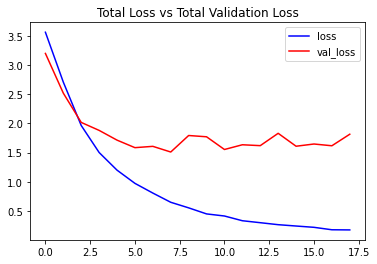

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

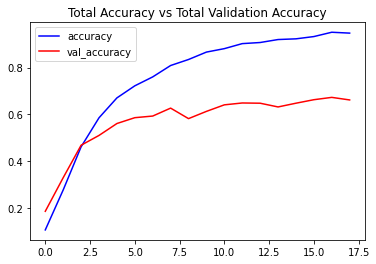

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

save model

In [ ]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_
{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Saving your Model
model.save(model_name)

plot model accuracy and loss

In [ ]:
# plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

TypeError: ignored

In [ ]:
# plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

### **<font style="color:rgb(134,19,348)">Step 5.1: Construct the Model</font>**

To implement our LRCN architecture, we will use time-distributed **`Conv2D`** layers which will be followed by **`MaxPooling2D`** and **`Dropout`** layers. The feature extracted from the **`Conv2D`** layers will be then flattened using the  **`Flatten`** layer and will be fed to a **`LSTM`** layer. The **`Dense`** layer with softmax activation will then use the output from the **`LSTM`** layer to predict the action being performed.

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

Now we will utilize the function **`create_LRCN_model()`** created above to construct the required `LRCN` model.

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 10, 64, 64, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 10, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 10, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 10, 16, 16, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 10, 4, 4, 32)    

#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**

Now we will use the **`plot_model()`** function to check the structure of the constructed `LRCN` model. As we had checked for the previous model.

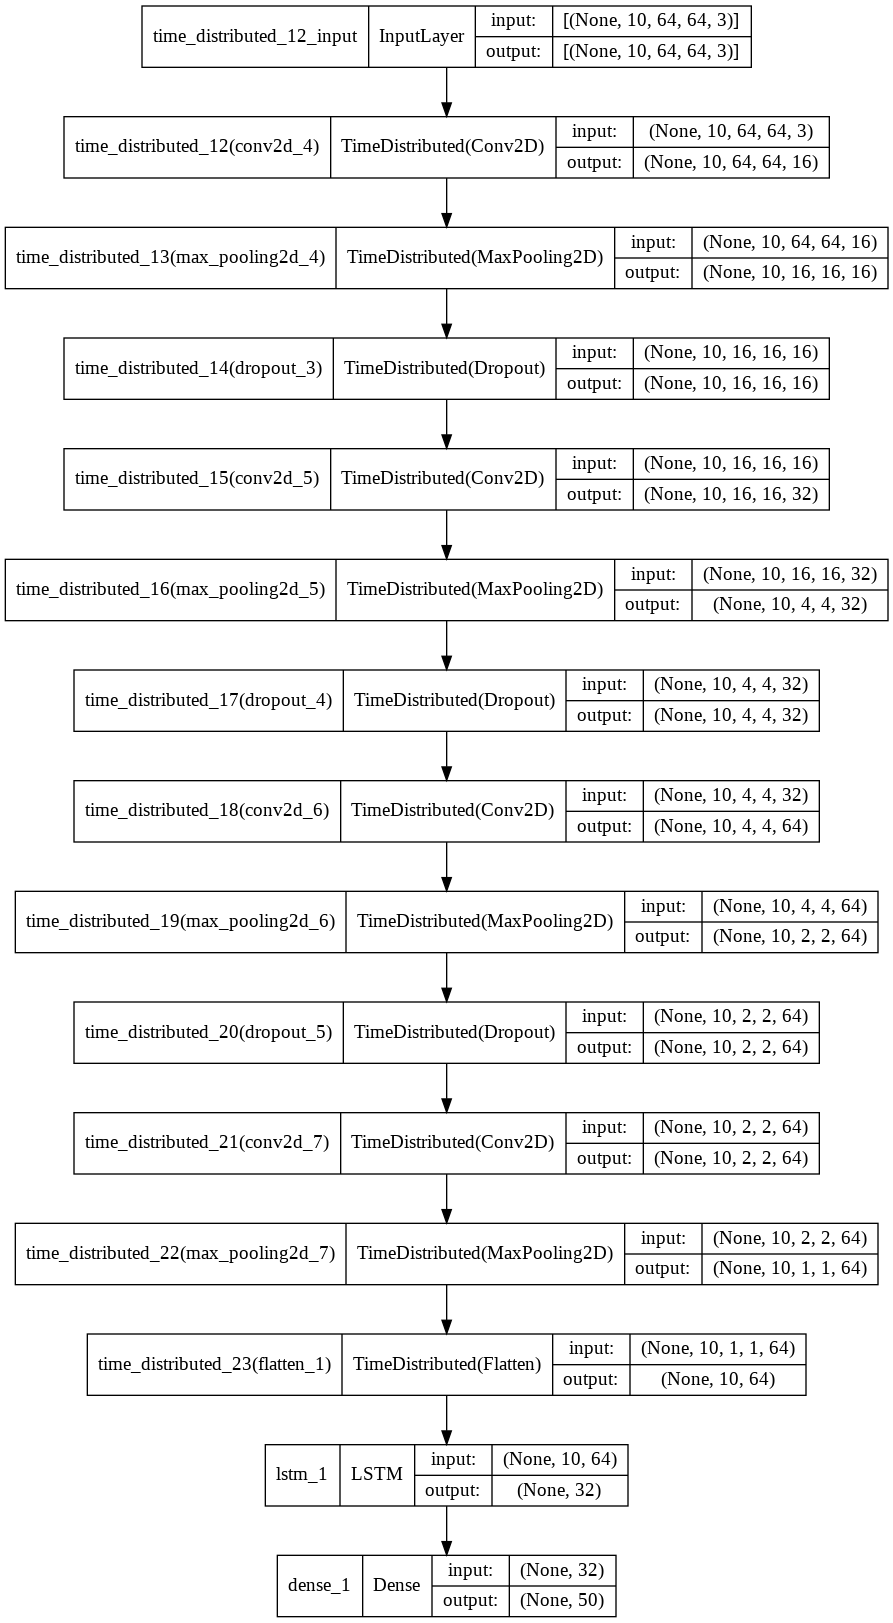

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **<font style="color:rgb(134,19,348)">Step 5.2: Compile & Train the Model</font>**


After checking the structure, we will compile and start training the model.

In [ ]:
%%time
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
1002/1002 [==============================] - 9s 7ms/step - loss: 3.8186 - accuracy: 0.0484 - val_loss: 3.5540 - val_accuracy: 0.1248
Epoch 2/70
1002/1002 [==============================] - 6s 6ms/step - loss: 3.3996 - accuracy: 0.1252 - val_loss: 3.2877 - val_accuracy: 0.1357
Epoch 3/70
1002/1002 [==============================] - 6s 6ms/step - loss: 3.1244 - accuracy: 0.1781 - val_loss: 3.0135 - val_accuracy: 0.2026
Epoch 4/70
1002/1002 [==============================] - 6s 6ms/step - loss: 2.9318 - accuracy: 0.2141 - val_loss: 2.8824 - val_accuracy: 0.2096
Epoch 5/70
1002/1002 [==============================] - 6s 6ms/step - loss: 2.7383 - accuracy: 0.2550 - val_loss: 2.7596 - val_accuracy: 0.2485
Epoch 6/70
1002/1002 [==============================] - 6s 6ms/step - loss: 2.5918 - accuracy: 0.2837 - val_loss: 2.7180 - val_accuracy: 0.2685
Epoch 7/70
1002/1002 [==============================] - 6s 6ms/step - loss: 2.4459 - accuracy: 0.3283 - val_loss: 2.6293 - val_accuracy:

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**

As done for the previous one, we will evaluate the `LRCN` model on the test set.

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

53/53 [==============================] - 0s 8ms/step - loss: 1.2920 - accuracy: 0.6918


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

After that, we will save the model for future uses using the same technique we had used for the previous model.

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Step 5.3: Plot Model’s Loss & Accuracy Curves</font>**

Now we will utilize the function **`plot_metric()`** we had created above to visualize the training and validation metrics of this model.


In [ ]:
# # Visualize the training and validation loss metrices.
# plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

NameError: ignored

In [ ]:
# # Visualize the training and validation accuracy metrices.
# plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
pred_LRCN = LRCN_model.predict(features_test)

In [ ]:
pred_LRCN.shape

(1671, 50)

In [ ]:
pred_classes_LRCN = np.argmax(pred_LRCN, axis = 1)
pred_classes_LRCN;

In [ ]:
y_label= np.argmax(labels_test, axis =1)

In [ ]:
labels_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

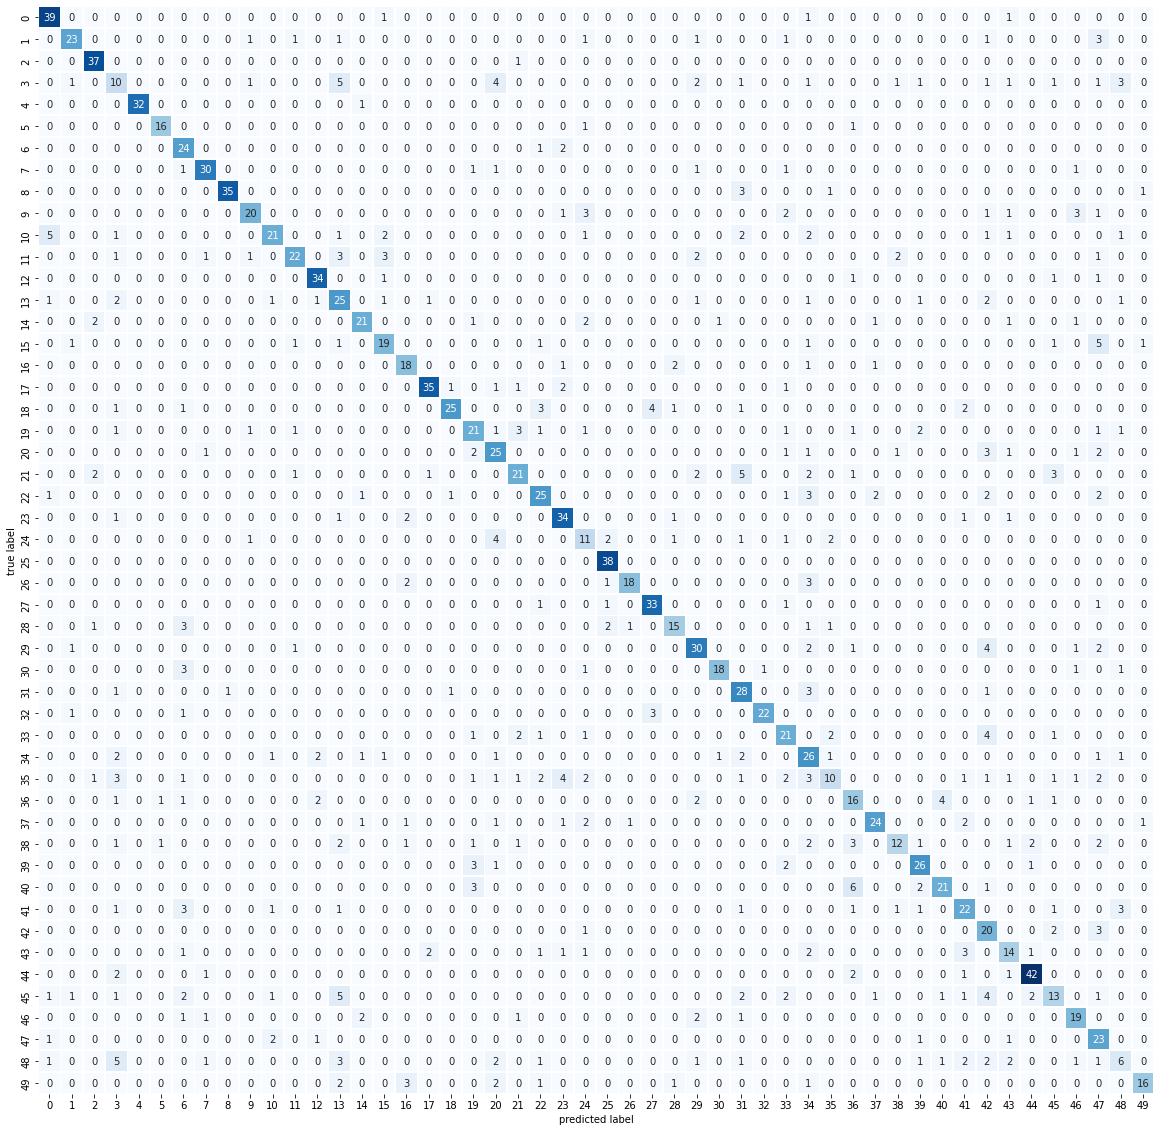

In [ ]:
plot_confusion_matrix(y_label,pred_classes_LRCN)

In [ ]:
print_validation_report(y_label,pred_classes_LRCN)

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.93      0.86        42
           1       0.82      0.70      0.75        33
           2       0.86      0.97      0.91        38
           3       0.29      0.29      0.29        34
           4       1.00      0.97      0.98        33
           5       0.89      0.89      0.89        18
           6       0.57      0.89      0.70        27
           7       0.86      0.83      0.85        36
           8       0.97      0.88      0.92        40
           9       0.80      0.62      0.70        32
          10       0.78      0.55      0.65        38
          11       0.81      0.61      0.70        36
          12       0.85      0.89      0.87        38
          13       0.50      0.66      0.57        38
          14       0.78      0.70      0.74        30
          15       0.68      0.61      0.64        31
          16       0.67      0.78      0.72        23
     